In [ ]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a6cfc899567110a1ff0b3ddfd45f7f7476d2cd52ea7450c1017215cec68c738b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd
import numpy as np
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import SnowballStemmer
from collections import Counter
import pymorphy2
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizerFast
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Загрузка ресурсов
1. Загружает данные для токенизации текста
2. Загружает список стоп-слов для различных языков
3. Создаёт множество (set) из списка стоп-слов для русского языка
4. Инициализирует объект MorphAnalyzer из библиотеки pymorphy2, который будет использоваться для лемматизации слов

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# def preprocess_text

Данная функция производит:

1. Приведение к нижнему регистру
2. Удаление всех символов не являющихся словами на пробелы
3. Разбивает текст на отдельные предложения
4. Разбивает каждое предложение на отдельные слова
5. Применяет лемматизацию к каждому слову, используя библиотеку pymorphy2
6. Возвращает все обработанные слова обратно в одну строку, разделенную пробелами

In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', ' ', text)

  sentences = nltk.sent_tokenize(text)
  processed_sentence = []

  for sentence in sentences:
    words = word_tokenize(sentence)

    preprocessed_words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
    processed_sentence.extend(preprocessed_words)


  return " ".join(processed_sentence)

#Загрузка данных
Данный блок кода проходится по всем файлам в GoogleDrive и обрабатывает исключительно .txt. Производит открытие и чтение файлов. Создает словарь в котором будет храниться ключ = имя файла, значение = весь текст файла.

In [ ]:
processed_texts = {}

for filename in os.listdir('/content/drive/MyDrive/Colab Notebooks/Книги'):
    if filename.endswith('.txt'):
        with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/Книги', filename), 'r', encoding='utf-8') as file:

            text = file.read()
            processed_texts[filename] = preprocess_text(text)

Преобразуем словарь в датафрейм

In [ ]:
df = pd.DataFrame.from_dict(processed_texts, orient = 'index',columns=['processed_text']).reset_index()
df.rename(columns={'index': 'filename'}, inplace= True)
df.to_csv('processed_book.csv', index = False)


Проверим длину текста для всего датафрейма

In [ ]:
lenght_df = df['processed_text'].str.len()
total_length = lenght_df.sum()
print(f'The total length of all texts: {total_length:.2f}')

The total length of all texts: 5410634.00


Проверим длину текста для каждой книги


In [ ]:
df['processed_text'].str.len()

0       55836
1      429453
2       27844
3        7448
4       62996
5       15696
6      398607
7       82155
8      192740
9      466222
10        855
11      39232
12      10327
13     153424
14      24529
15      17526
16     194776
17      63862
18     101864
19      54949
20      74920
21      52082
22      78034
23     106003
24    2139084
25     560170
Name: processed_text, dtype: int64

Расчитываем среднюю длинну книги в датафрейме

In [ ]:
mean_len_all_books = df['processed_text'].str.len().mean()
print(f'Mean length all books:{mean_len_all_books: .2f}')


Mean length all books: 208101.31


Данная тепловая карта показывает вес каждой книги в датафрейме.

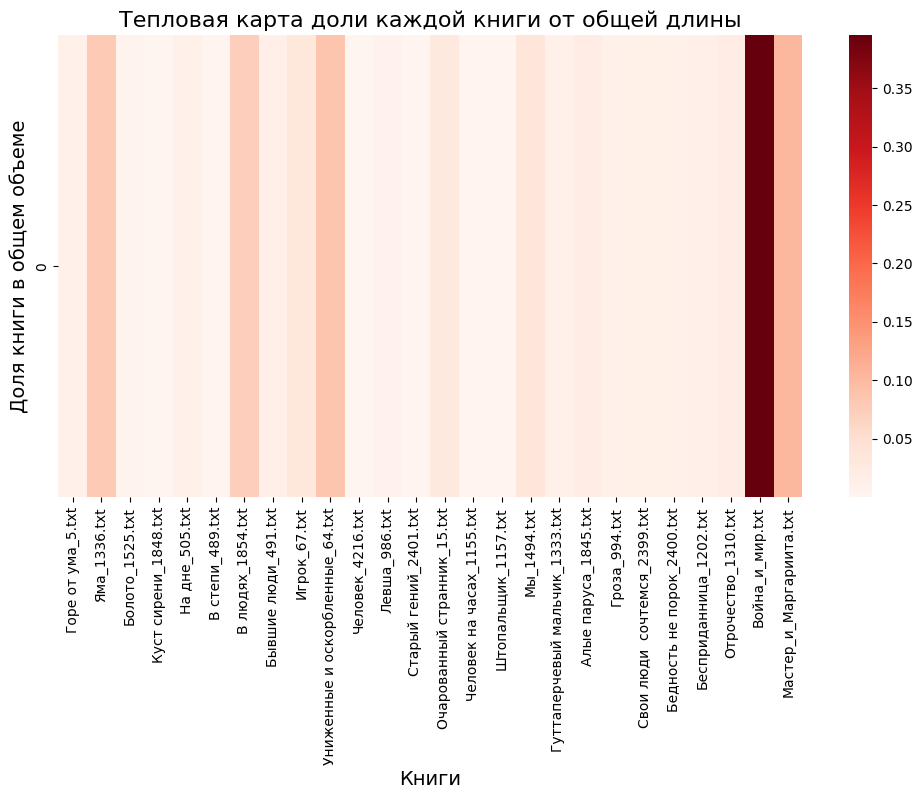

In [ ]:
length_df = df['processed_text'].str.len()

length_ratio = length_df / total_length

heatmap_data = np.array(length_ratio).reshape(1, -1)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', cbar=True, xticklabels=df['filename'])

plt.title('Тепловая карта доли каждой книги от общей длины', fontsize=16)
plt.xlabel('Книги', fontsize=14)
plt.ylabel('Доля книги в общем объеме', fontsize=14)
plt.xticks(rotation=90)
plt.show()

Просмотр самых частых слов для всего датафрейма

In [ ]:
# Самые частые слова во всем датафрейме
words_all = " ".join(df['processed_text']).split()
words_counter = Counter(words_all)
print(words_counter.most_common(10))


[('это', 8166), ('сказать', 6164), ('который', 5625), ('говорить', 5362), ('свой', 5162), ('человек', 4285), ('знать', 3735), ('один', 3016), ('рука', 2952), ('мочь', 2550)]


Просмотр самых частых слов для каждой книги

In [ ]:
# Самые частые слова в книге
for i in range(len(df)):
  words_str = df['processed_text'].iloc[i].split()
  words_count = Counter(words_str)
  print(words_count.most_common(5))

[('чацкий', 56), ('ах', 52), ('сказать', 51), ('кто', 51), ('человек', 51)]
[('это', 532), ('который', 425), ('свой', 402), ('сказать', 359), ('лихонина', 285)]
[('землемер', 35), ('степан', 32), ('студент', 29), ('сердюков', 26), ('это', 26)]
[('куст', 14), ('вера', 13), ('говорить', 13), ('какой', 11), ('алмаз', 10)]
[('лука', 175), ('пепел', 160), ('бубновый', 154), ('человек', 139), ('сатина', 134)]
[('солдат', 43), ('человек', 30), ('студент', 30), ('идти', 25), ('сказать', 24)]
[('это', 643), ('говорить', 552), ('человек', 520), ('сказать', 384), ('всё', 380)]
[('человек', 145), ('ротмистр', 136), ('это', 118), ('свой', 97), ('учитель', 95)]
[('это', 401), ('бабушка', 238), ('всё', 231), ('генерал', 222), ('знать', 211)]
[('это', 1033), ('всё', 790), ('наташа', 570), ('говорить', 544), ('знать', 506)]
[('человек', 6), ('молодой', 3), ('раб', 3), ('свой', 3), ('который', 3)]
[('говорить', 122), ('государь', 89), ('левша', 82), ('это', 79), ('плат', 65)]
[('это', 31), ('старушка', 

Создадим общее облако слов

In [ ]:
#Общее облако слов
from wordcloud import WordCloud

def generate_wordcloud(data):
  text =' '.join(data)
  wordcloud = WordCloud(width=800, height = 800, background_color = 'black', max_font_size = 100, max_words = 100).generate(text)

  plt.figure(figsize = (16,8))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.title('Word Cloud')
  plt.axis('off')
  plt.show()

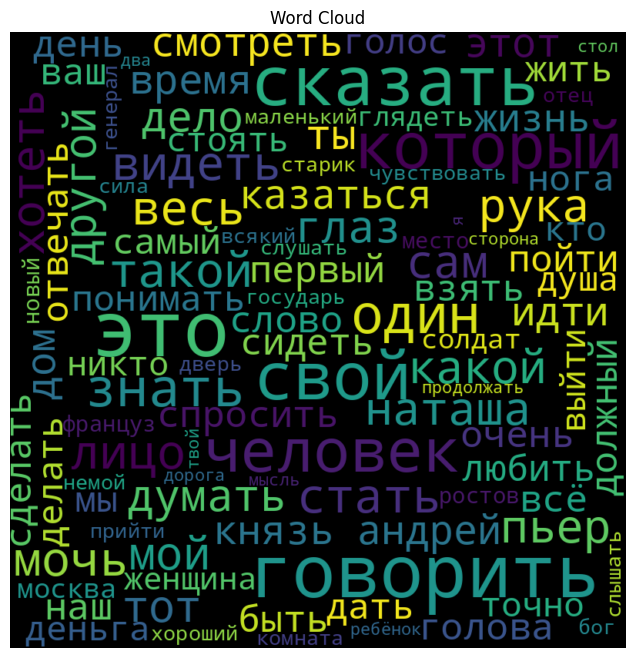

In [ ]:
generate_wordcloud(df['processed_text'])

Облако слов для определенной книги определяемое по индексу

In [ ]:
# Облако слов для определенной книги

index = 25; #Выбираем строку датафрейма(книгу) 9 12 25

def generate_wordcloud_book(data, index):
  text = data.iloc[index]
  wordcloud = WordCloud(width=800, height = 800, background_color = 'black', max_font_size = 100, max_words = 100).generate(text)

  plt.figure(figsize = (16,8))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.title('Word Cloud')
  plt.axis('off')
  plt.show()

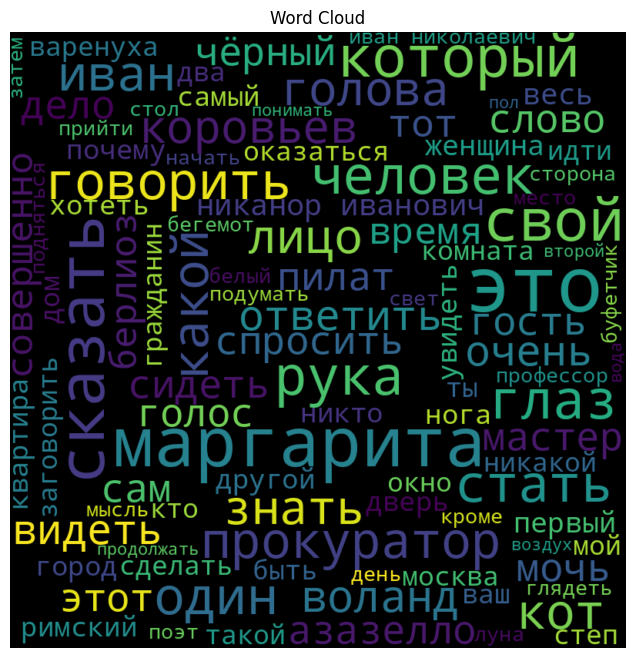

In [ ]:
generate_wordcloud_book(df['processed_text'], index)

Расчитываем и добавляем новый столбец длинна каждой книги. Считаем и добовляем столбец со средней длинной слова в каждой книге.

In [ ]:
df2 = df
df2['text_lenght'] = df2['processed_text'].apply(len)
df2['mean_lenght_word'] = df2['processed_text'].apply(
    lambda text: sum(map(len, text.split())) / len(text.split())
    if text.split() else 0)


In [ ]:
df2

filename  \
0                 Горе от ума_5.txt   
1                      Яма_1336.txt   
2                   Болото_1525.txt   
3              Куст сирени_1848.txt   
4                    На дне_505.txt   
5                   В степи_489.txt   
6                  В людях_1854.txt   
7               Бывшие люди_491.txt   
8                      Игрок_67.txt   
9   Униженные и оскорбленные_64.txt   
10                 Человек_4216.txt   
11                    Левша_986.txt   
12          Старый гений_2401.txt   
13     Очарованный странник_15.txt   
14        Человек на часах_1155.txt   
15              Штопальщик_1157.txt   
16                      Мы_1494.txt   
17  Гуттаперчевый мальчик_1333.txt   
18             Алые паруса_1845.txt   
19                    Гроза_994.txt   
20     Свои люди  сочтемся_2399.txt   
21       Бедность не порок_2400.txt   
22           Бесприданница_1202.txt   
23              Отрочество_1310.txt   
24                 Война_и_мир.txt   
25          Мастер_и_Маргариита.txt   

                                       processed_text  text_lenght  \
0   павел афанасиевич фамус управлять казённый мес...        55836   
1   александр куприн знать многие найти повесть бе...       429453   
2   александр куприн летний вечер гаснуть засыпать...        27844   
3   николай евграфович алмаз едва дождаться пока ж...         7448   
4   михаил иванов костылев 54 год содержатель ночл...        62996   
5   выйти перекоп сам скверный настроение дух голо...        15696   
6   человек служить мальчик магазин модный обувь г...       398607   
7   въезжий улица это ряд одноэтажный лачужка тесн...        82155   
8   возвратиться мой двухнедельный отлучка наш ден...       192740   
9   прошлое год двадцать второй март вечером я слу...       466222   
10  высокий стройный брюнет молодой достаточно пож...          855   
11  николай лесков император александр павлович ок...        39232   
12  гений год иметь преодолевать останавливать обы...        10327   
13  плыть ладожский озеро остров коневиц валаам пу...       153424   
14  николай лесков событие рассказ который ниже си...        24529   
15  николай лесков преглупый это пожелание сулить ...        17526   
16  евгений замятин просто списывать слово слово с...       194776   
17  дмитрий григорович родиться заплакать впоследс...        63862   
18  александр грин пбг 23 ноябрь 1922 г лонгрена м...       101864   
19  александр островский савел прокофиевич дикий к...        54949   
20  самсон силыч большов купец аграфена кондратиев...        74920   
21  посвятить пров михаилович садовский гордей кар...        52082   
22  александр островский харита игнатиевич огудало...        78034   
23  лев толстой снова подать экипаж крыльцо петров...       106003   
24  л н толстой война мир i eh bien mon prince gên...      2139084   
25  михаил булгаков мастер маргарита часть первый ...       560170   

    mean_lenght_word  
0           6.206634  
1           6.831036  
2           6.793171  
3           6.719171  
4           5.976412  
5           6.428774  
6           6.465967  
7           6.609856  
8           6.644509  
9           6.603983  
10          6.642857  
11          6.726073  
12          6.599706  
13          6.373366  
14          7.093039  
15          6.637037  
16          6.470162  
17          6.883348  
18          6.704788  
19          6.095816  
20          6.726204  
21          6.206725  
22          6.659501  
23          6.649852  
24          6.659394  
25          6.911014

#Определение лексического разнообразия

Функция lexical_div рассчитывает лексическое разнообразие текста, что представляет собой соотношение уникальных слов к общему числу слов в тексте. Чем выше это соотношение, тем разнообразнее лексика текста.

Индекс лексического разнообразия (LD)

Это более сложный показатель, который корректирует TTR для длинных текстов. Он помогает предотвратить искажение, вызванное длиной текста.



In [ ]:
# Определение лексического разнообразия каждой книги
def lexical_div(text):
  words = text.split()
  if len(words) > 0:
    return len(set(words)) / len(words)
  else: return 0

In [ ]:
df2['lexical_div'] = df2['processed_text'].apply(lexical_div)
df2

filename  \
0                 Горе от ума_5.txt   
1                      Яма_1336.txt   
2                   Болото_1525.txt   
3              Куст сирени_1848.txt   
4                    На дне_505.txt   
5                   В степи_489.txt   
6                  В людях_1854.txt   
7               Бывшие люди_491.txt   
8                      Игрок_67.txt   
9   Униженные и оскорбленные_64.txt   
10                 Человек_4216.txt   
11                    Левша_986.txt   
12          Старый гений_2401.txt   
13     Очарованный странник_15.txt   
14        Человек на часах_1155.txt   
15              Штопальщик_1157.txt   
16                      Мы_1494.txt   
17  Гуттаперчевый мальчик_1333.txt   
18             Алые паруса_1845.txt   
19                    Гроза_994.txt   
20     Свои люди  сочтемся_2399.txt   
21       Бедность не порок_2400.txt   
22           Бесприданница_1202.txt   
23              Отрочество_1310.txt   
24                 Война_и_мир.txt   
25          Мастер_и_Маргариита.txt   

                                       processed_text  text_lenght  \
0   павел афанасиевич фамус управлять казённый мес...        55836   
1   александр куприн знать многие найти повесть бе...       429453   
2   александр куприн летний вечер гаснуть засыпать...        27844   
3   николай евграфович алмаз едва дождаться пока ж...         7448   
4   михаил иванов костылев 54 год содержатель ночл...        62996   
5   выйти перекоп сам скверный настроение дух голо...        15696   
6   человек служить мальчик магазин модный обувь г...       398607   
7   въезжий улица это ряд одноэтажный лачужка тесн...        82155   
8   возвратиться мой двухнедельный отлучка наш ден...       192740   
9   прошлое год двадцать второй март вечером я слу...       466222   
10  высокий стройный брюнет молодой достаточно пож...          855   
11  николай лесков император александр павлович ок...        39232   
12  гений год иметь преодолевать останавливать обы...        10327   
13  плыть ладожский озеро остров коневиц валаам пу...       153424   
14  николай лесков событие рассказ который ниже си...        24529   
15  николай лесков преглупый это пожелание сулить ...        17526   
16  евгений замятин просто списывать слово слово с...       194776   
17  дмитрий григорович родиться заплакать впоследс...        63862   
18  александр грин пбг 23 ноябрь 1922 г лонгрена м...       101864   
19  александр островский савел прокофиевич дикий к...        54949   
20  самсон силыч большов купец аграфена кондратиев...        74920   
21  посвятить пров михаилович садовский гордей кар...        52082   
22  александр островский харита игнатиевич огудало...        78034   
23  лев толстой снова подать экипаж крыльцо петров...       106003   
24  л н толстой война мир i eh bien mon prince gên...      2139084   
25  михаил булгаков мастер маргарита часть первый ...       560170   

    mean_lenght_word  lexical_div  
0           6.206634     0.420367  
1           6.831036     0.215044  
2           6.793171     0.532326  
3           6.719171     0.643523  
4           5.976412     0.268106  
5           6.428774     0.546616  
6           6.465967     0.182075  
7           6.609856     0.344943  
8           6.644509     0.207552  
9           6.603983     0.126238  
10          6.642857     0.848214  
11          6.726073     0.409216  
12          6.599706     0.551876  
13          6.373366     0.277345  
14          7.093039     0.474761  
15          6.637037     0.481481  
16          6.470162     0.215579  
17          6.883348     0.375633  
18          6.704788     0.360109  
19          6.095816     0.261880  
20          6.726204     0.268949  
21          6.206725     0.279923  
22          6.659501     0.259128  
23          6.649852     0.290900  
24          6.659394     0.072788  
25          6.911014     0.154867

#Определяем коэффициент повторяемости
Коэффициент повторяемости (Repetition Rate)
Измеряет, сколько слов повторяется в тексте, что может быть полезно для выявления текста с высокой степенью повторений.

In [ ]:
def repetition_rate(text):
    words = text.split()
    word_counts = Counter(words)
    repeated_words = []

   # Проходим по всем словам и их частотам в словаре
    for word, count in word_counts.items():
        if count > 1: repeated_words.append(word) # Если слово повторяется более одного раза, добавляем его в список

    if len(words) > 0:
      return len(repeated_words) / len(words)
    else: return 0

Добовляем столбец коэффициент повторяемости в датафрейм

In [ ]:
df2['repetition_rate'] = df2['processed_text'].apply(repetition_rate)
df2

filename  \
0                 Горе от ума_5.txt   
1                      Яма_1336.txt   
2                   Болото_1525.txt   
3              Куст сирени_1848.txt   
4                    На дне_505.txt   
5                   В степи_489.txt   
6                  В людях_1854.txt   
7               Бывшие люди_491.txt   
8                      Игрок_67.txt   
9   Униженные и оскорбленные_64.txt   
10                 Человек_4216.txt   
11                    Левша_986.txt   
12          Старый гений_2401.txt   
13     Очарованный странник_15.txt   
14        Человек на часах_1155.txt   
15              Штопальщик_1157.txt   
16                      Мы_1494.txt   
17  Гуттаперчевый мальчик_1333.txt   
18             Алые паруса_1845.txt   
19                    Гроза_994.txt   
20     Свои люди  сочтемся_2399.txt   
21       Бедность не порок_2400.txt   
22           Бесприданница_1202.txt   
23              Отрочество_1310.txt   
24                 Война_и_мир.txt   
25          Мастер_и_Маргариита.txt   

                                       processed_text  text_lenght  \
0   павел афанасиевич фамус управлять казённый мес...        55836   
1   александр куприн знать многие найти повесть бе...       429453   
2   александр куприн летний вечер гаснуть засыпать...        27844   
3   николай евграфович алмаз едва дождаться пока ж...         7448   
4   михаил иванов костылев 54 год содержатель ночл...        62996   
5   выйти перекоп сам скверный настроение дух голо...        15696   
6   человек служить мальчик магазин модный обувь г...       398607   
7   въезжий улица это ряд одноэтажный лачужка тесн...        82155   
8   возвратиться мой двухнедельный отлучка наш ден...       192740   
9   прошлое год двадцать второй март вечером я слу...       466222   
10  высокий стройный брюнет молодой достаточно пож...          855   
11  николай лесков император александр павлович ок...        39232   
12  гений год иметь преодолевать останавливать обы...        10327   
13  плыть ладожский озеро остров коневиц валаам пу...       153424   
14  николай лесков событие рассказ который ниже си...        24529   
15  николай лесков преглупый это пожелание сулить ...        17526   
16  евгений замятин просто списывать слово слово с...       194776   
17  дмитрий григорович родиться заплакать впоследс...        63862   
18  александр грин пбг 23 ноябрь 1922 г лонгрена м...       101864   
19  александр островский савел прокофиевич дикий к...        54949   
20  самсон силыч большов купец аграфена кондратиев...        74920   
21  посвятить пров михаилович садовский гордей кар...        52082   
22  александр островский харита игнатиевич огудало...        78034   
23  лев толстой снова подать экипаж крыльцо петров...       106003   
24  л н толстой война мир i eh bien mon prince gên...      2139084   
25  михаил булгаков мастер маргарита часть первый ...       560170   

    mean_lenght_word  lexical_div  repetition_rate  
0           6.206634     0.420367         0.147909  
1           6.831036     0.215044         0.106346  
2           6.793171     0.532326         0.158410  
3           6.719171     0.643523         0.177202  
4           5.976412     0.268106         0.116279  
5           6.428774     0.546616         0.145291  
6           6.465967     0.182075         0.096984  
7           6.609856     0.344943         0.142645  
8           6.644509     0.207552         0.105144  
9           6.603983     0.126238         0.072611  
10          6.642857     0.848214         0.080357  
11          6.726073     0.409216         0.142970  
12          6.599706     0.551876         0.158205  
13          6.373366     0.277345         0.119521  
14          7.093039     0.474761         0.161993  
15          6.637037     0.481481         0.157734  
16          6.470162     0.215579         0.110570  
17          6.883348     0.375633         0.157388  
18          6.704788     0.360109         0.148249  
19          6.095816  

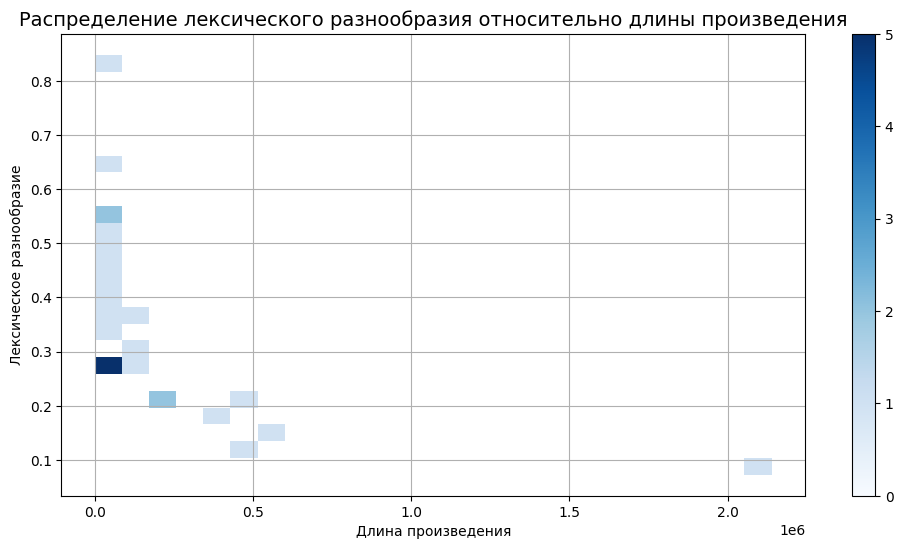

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df2, y='lexical_div', x='text_lenght', bins = 25, cbar=True, cmap='Blues')

plt.title('Распределение лексического разнообразия относительно длины произведения', fontsize=14)
plt.ylabel('Лексическое разнообразие', fontsize=10)
plt.xlabel('Длина произведения', fontsize=10)
plt.grid(True)

plt.show()

Данная тепловая карта показывает, что чем длиннее произведение тем сильнее ухудшается лексическое разнообразие. Области с более тёмным синим цветом указывают, где большинство произведений сосредоточены в терминах длины и лексического разнообразия. Самыми лексически разннобразными произведениями являются короткие.

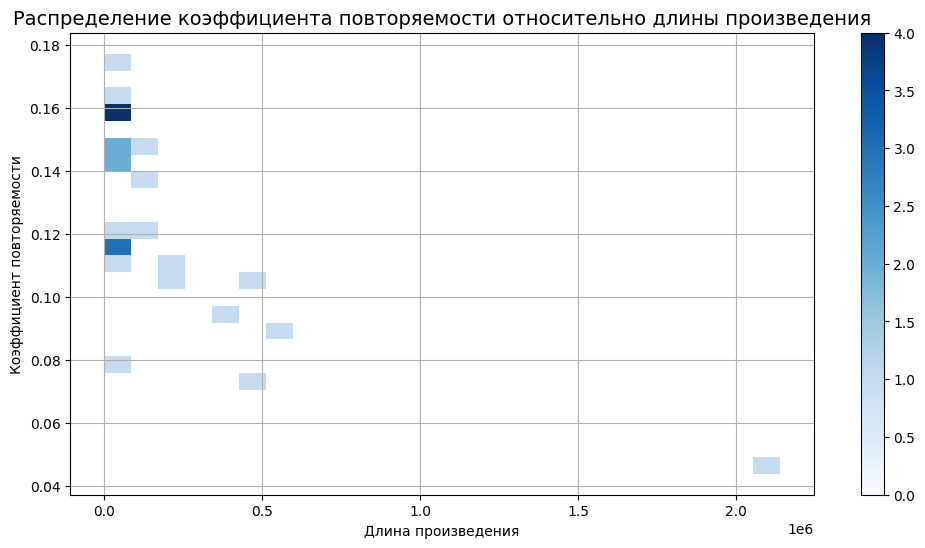

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df2, y='repetition_rate', x='text_lenght', bins = 25, cbar=True, cmap='Blues')

plt.title('Распределение коэффициента повторяемости относительно длины произведения', fontsize=14)
plt.ylabel('Коэффициент повторяемости', fontsize=10)
plt.xlabel('Длина произведения', fontsize=10)
plt.grid(True)

plt.show()

Данная тепловая карта показывает коэффициент повторяемости относительно длины произведения. Относительно предыдущего графика противоположные показатели. Чем больше произведение тем повторяемость ниже. Что логично.

#Анализ эмоциональной окраски
Эта функция анализирует эмоциональную окраску текста с использованием модели BERT для русского языка (blanchefort/rubert-base-cased-sentiment).

Функция принимает текст и разбивает его на части, если текст слишком длинный (например, книга), анализирует каждый фрагмент текста по отдельности, а затем усредняет результаты для всего текста.

Функция возвращает:
1. Список вероятностей для трех классов сентимента.
2. Значение compound, которое представляет собой итоговый баланс сентимента для всего текста

In [ ]:
MODEL_NAME = "blanchefort/rubert-base-cased-sentiment" # Модель для анализа тональности на русском языке
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Подключение к GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Функция для анализа текста с использованием BERT
def analyze_text_bert(text):
    # Токенизация текста
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    # Прогон текста через модель
    with torch.no_grad():
        outputs = model(**inputs)
    # Получение вероятностей через softmax
    probabilities = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    # Классы: [негативный, нейтральный, позитивный]
    return probabilities.tolist()

# Функция для анализа длинных текстов (например, книг)
def analyze_long_text_bert(text, chunk_size=512):
    # Разбиение текста на части
    sentences = sent_tokenize(text)
    # Формирование фрагментов (chunks) из предложений
    chunks = [" ".join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]

    results = []
    for chunk in chunks:
        # Анализ каждого фрагмента
        result = analyze_text_bert(chunk)
        results.append(result)
    # Усреднение вероятностей для всего текста
    averaged_result = np.mean(results, axis=0).tolist()
    averaged_result = [round(val, 2) for val in averaged_result]
    # Расчет compound с учетом всех трех классов
    compound = (averaged_result[2] - averaged_result[0]) * 0.5 + averaged_result[1] * 0.5
    compound = round(compound, 2)


    return averaged_result, compound

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

Добавление столбцов в датафрейм с расчетами эммоциональной окраски analyze_stil - список вероятностей для трех классов сентимента. compound - общая оценка на основе трех классов.

In [ ]:
df2[['analyze_stil', 'compound']] = df2['processed_text'].apply(lambda text: pd.Series(analyze_long_text_bert(text)))

#Общая интерпретация

Положительные значения в столбце compound указывают на преобладание позитивного сентимента, тогда как отрицательные значения свидетельствуют о преобладании негативного сентимента.
Значения около 0 указывают на нейтральную окраску текста, что может свидетельствовать о смешанных эмоциях или отсутствии явной эмоциональной нагрузки.

Сравнение произведений:
Позитивные произведения (высокие значения compound):

Горе от ума (compound = 0.27): Позитивный сентимент, но с умеренно позитивной окраской.
Яма (compound = 0.32): Также с позитивной окраской.
На дне (compound = 0.32), В людях (compound = 0.32), Игрок (compound = 0.32) и другие тексты с аналогичными значениями (около 0.32) также имеют умеренно положительную эмоциональную окраску.
Негативные произведения (низкие значения compound):

Болото (compound = -0.29): Это произведение имеет негативную эмоциональную окраску.
Куст сирени (compound = -0.31): Аналогично, имеет негативный сентимент.
Старый гений (compound = -0.28), Очарованный странник (compound = -0.32) также имеют негативную окраску.
Штопальщик (compound = -0.21) тоже указывает на более низкий сентимент.
Нейтральные произведения (значения близки к 0):

Произведения с compound = 0.32: большинство произведений имеют значение около 0.32, что говорит о нейтрально-позитивной окраске текста.



In [ ]:
# В столбце analyze_stil результат анализа выглядит так: негативный, нейтральный, позитивный
df2[['filename','analyze_stil', 'compound']]

filename        analyze_stil  compound
0                 Горе от ума_5.txt  [0.23, 0.71, 0.06]      0.27
1                      Яма_1336.txt  [0.18, 0.07, 0.75]      0.32
2                   Болото_1525.txt  [0.79, 0.17, 0.04]     -0.29
3              Куст сирени_1848.txt  [0.81, 0.16, 0.03]     -0.31
4                    На дне_505.txt  [0.18, 0.07, 0.75]      0.32
5                   В степи_489.txt  [0.81, 0.15, 0.04]     -0.31
6                  В людях_1854.txt  [0.18, 0.07, 0.75]      0.32
7               Бывшие люди_491.txt   [0.8, 0.16, 0.04]     -0.30
8                      Игрок_67.txt  [0.18, 0.07, 0.75]      0.32
9   Униженные и оскорбленные_64.txt  [0.18, 0.07, 0.75]      0.32
10                 Человек_4216.txt   [0.34, 0.6, 0.06]      0.16
11                    Левша_986.txt  [0.18, 0.07, 0.75]      0.32
12          Старый гений_2401.txt  [0.78, 0.19, 0.04]     -0.28
13     Очарованный странник_15.txt  [0.82, 0.15, 0.03]     -0.32
14        Человек на часах_1155.txt  [0.18, 0.07, 0.75]      0.32
15              Штопальщик_1157.txt  [0.71, 0.24, 0.05]     -0.21
16                      Мы_1494.txt  [0.18, 0.07, 0.75]      0.32
17  Гуттаперчевый мальчик_1333.txt  [0.81, 0.16, 0.03]     -0.31
18             Алые паруса_1845.txt  [0.18, 0.07, 0.75]      0.32
19                    Гроза_994.txt  [0.03, 0.96, 0.01]      0.47
20     Свои люди  сочтемся_2399.txt  [0.03, 0.96, 0.01]      0.47
21       Бедность не порок_2400.txt  [0.18, 0.07, 0.75]      0.32
22           Бесприданница_1202.txt  [0.04, 0.95, 0.01]      0.46
23              Отрочество_1310.txt  [0.18, 0.07, 0.75]      0.32
24                 Война_и_мир.txt  [0.18, 0.07, 0.75]      0.32
25          Мастер_и_Маргариита.txt  [0.18, 0.07, 0.75]      0.32

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['compound'].plot(kind='hist', bins=20, title='compound')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='compound', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['compound']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('compound')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['compound'].plot(kind='line', figsize=(8, 4), title='compound')
plt.gca().spines[['top', 'right']].set_visible(False)

#Горе от ума

Реальная интерпретация: Это произведение часто воспринимается как острое сатирическое произведение, критикующее общественные пороки и высокомерие. Эмоциональная окраска может быть как нейтральной, так и легкой сатирической.
Полученные данные: compound = 0.27
Противоречие: Нет

#Яма

Реальная интерпретация: Это произведение Достоевского о социальной несправедливости и безысходности, что воспринимается как трагическое.
Полученные данные: Позитивный сентимент с небольшим акцентом на нейтральный.
Противоречие: Да. Возможно связанно с ограничением интерпритации модели. Не может воспринять контекст эммоций.

#Болото

Реальная интерпретация: Произведение имеет глубокую пессимистичную окраску, затрагивает моральные и социальные проблемы, включая разочарование и безнадежность.
Полученные данные: Негативно-нейтральный сентимент (compound = -0.29)
Противоречие: Нет явного противоречия.

#Куст сирени

Реальная интерпретация: Произведение часто ассоциируется с меланхолией, романтизмом и обостренными переживаниями, а не с чисто негативными эмоциями.
Полученные данные: Негативно-нейтральный сентимент (compound = -0.31).
Противоречие: Да. Данная ошибочная оценка возможно связана с ложным воспринятием моделей меланхоличных аспектов, переживания. Принятые за негативные эмоции.

#На дне

Реальная интерпретация: Произведение изображены люди, находящиеся на дне социальной и моральной ямы, что вызывает сочувствие и сострадание.
Полученные данные: Позитивно-нейтральный сентимент (compound = 0.32).
Противоречие: Да, произведение является трагическим и описывает глубокие страдания людей. Данная оценка возможно связана с повествовательным типом пердложения, которое ей сложно обработать верно. Негативные сентимет теряется на фоне длинного повествования.

#В степи

Реальная интерпретация: Произведение описывает сложные моральные дилеммы и образы людей, погруженных в раздумья о жизни и смерти.
Полученные данные: Негативный-нейтральный сентимент (compound = -0.31).
Противоречие: Нет. Данное произведение больше философского характера. Так как в нем фигурирует вопрос "жизни и смерти". Модель считывает данный аспект и дает около нейтральную оценку с негативным направлением.

#В людях

Реальная интерпретация: Острое социальное произведение, раскрывающее проблемы бедности и морального разложения.
Полученные данные: Позитивно-нейтральный сентимент (compound = 0.32).
Противоречие: Да, произведение имеет пессимистичную и социальную окраску. Позитивный сентимент явно не отражает всю сложность и критику социальной несправедливости, на которую обращает внимание автор. Возможно связанно с ограничением интерпритации модели. Не может воспринять контекст эммоций.

#Бывшие люди

Реальная интерпретация: Произведение о людях, утрачивающих свою моральную ценность и место в обществе. Это произведение воспринимается как трагическое и грустное.
Полученные данные: Негативный-нейтральный сентимент (compound = -0.30).
Противоречие: Нет противоречий, негативная эмоциональная окраска соответствует содержанию.

#Игрок

Реальная интерпретация: Психологическая драма о человеческой страсти и разрушении, что воспринимается как смесь трагического и экзистенциального.
Полученные данные: Позитивно-нейтральный (compound = 0.32).
Противоречие: Да, несмотря на богатое содержание с психологическим конфликтом, сентиментальная окраска данных больше указывает на нейтральность и вряд ли передает весь драматизм ситуации. Данная оценка возможно связанна с особенностями произведения, в котором фигурирует азарт и эфория от выйгрыша. Модели сложно определить скрытый подтест.

#Униженные и оскорбленные

Реальная интерпретация: Это произведение, как правило, воспринимается как трагическое и фаталистическое, со значительным акцентом на страдания людей.
Полученные данные: Позитивно-нейтральный сентимент (compound = 0.32).
Противоречие: Да, произведение имеет тяжелый и трагический смысл, а полученные данные не отражают всей сложности ситуаций, изображенных в нем.

#Левша

Реальная интерпретация: Сатирическое произведение с элементами иронии и глубоким философским подтекстом.
Полученные данные: Позитивный-нейтральный сентимент (compound = 0.32).
Противоречие: Нет, данные подходят для этой остроумной и философской истории.

#Старый гений

Реальная интерпретация: Печальная история о разочаровании и утрате.
Полученные данные: Негативно-нейтральный сентимент (compound = -0.28).
Противоречие: Нет, результаты соответствуют настроению произведения.

#Очарованный странник

Реальная интерпретация: Легкая меланхолия, романтическая тоска.
Полученные данные: Негативный-нейтральное сентимент (compound = -0.32).
Противоречие: естьнекоторое противоречие, не считывает скрытый контекст. Однако если оприаться относительно содержания определил верно.

#Человек на часах

Реальная интерпретация: Легкий, сдержанный рассказ, не имеющий яркой эмоциональной окраски.
Полученные данные: Позитивный-нейтральный сентимент (compound = 0.32).
Противоречие: Нет, данные отражают нейтральную или умеренно позитивную окраску.

#Штопальщик

Реальная интерпретация: Меланхоличная и философская история.
Полученные данные: Негативно-нейтральный сентимент (compound = -0.21).
Противоречие: Нет, данные соответствуют настроению произведения.

#Мы

Реальная интерпретация: Дистопия с темой социальной справедливости и подавления.
Полученные данные: Позитивно-нейтральный сентимент (compound = 0.32).
Противоречие: Да, результат не передает мрачной и подавляющей атмосферы произведения. Сложность к восприятию, скрытого контекста и философских смыслов.

#Гуттаперчевый мальчик

Реальная интерпретация: Социальная критика, часто с элементами трагизма.
Полученные данные: Негативный сентимент (compound = -0.31).
Противоречие: Нет, данные отражают тональность произведения.

#Алые паруса

Реальная интерпретация: Романтика, мечта и надежда.
Полученные данные: Позитивный сентимент (compound = 0.32).
Противоречие: Нет, результаты согласуются с идеалистическим настроем.

#Гроза

Реальная интерпретация: Мрачное произведение о судьбе женщин в патриархальном обществе.
Полученные данные: Позитивный сентимент (compound = 0.47).
Противоречие: Да, позитивный сентимент не отражает трагизма произведения.

#Свои люди сочтемся

Реальная интерпретация: Легкий комедийный стиль с критикой социальной среды.
Полученные данные: Позитивный сентимент (compound = 0.47).
Противоречие: Нет, данные соответствуют легкому комедийному настрою.

#Бедность не порок

Реальная интерпретация: Позитивная идея преодоления трудностей.
Полученные данные: Позитивный сентимент (compound = 0.32).
Противоречие: Нет, данные отражают позитивный настрой.

#Бесприданница

Реальная интерпретация: Трагическая история о любви и предательстве.
Полученные данные: Позитивный сентимент (compound = 0.46).
Противоречие: Да, данные не отражают трагичность произведения.

#Отрочество

Реальная интерпретация: Произведение о взрослении с элементами меланхолии.
Полученные данные: Позитивный сентимент (compound = 0.32).
Противоречие: Нет, данные показывают легкую позитивную окраску.

#Война и мир

Реальная интерпретация: Эпическое произведение с глубокими философскими размышлениями и трагическими моментами.
Полученные данные: Позитивный сентимент (compound = 0.32).
Противоречие: Да, произведение охватывает трагедию войны и раздумья о жизни, что не всегда соответствует полученному результату. Однако, данное произведение очень большое и имеет много описательных и повествовательных моментов, модель теряется в этом многообразии.

# Мастер и Маргарита

Реальная интерпретация: Это философский роман, насыщенный мифологическими и трагическими мотивами.
Полученные данные: Позитивно-нейтральный сентимент (compound = 0.32).
Противоречие: Нет, произведение имеет темные и философские элементы, и позитивный сентимент.

#Итог

Данная модель хорошо справляется с произведениями позитивной окраски и резко негативными. Ей сложно обрабатывать произведения находящиеся на грани, в которых много размышлений и философского подтекста. Тоесть того, что нацелено на реального человека, где необходимо размышлять и осмыслять скрытые подтексты и то что хотел сказать автор. Если основывать грубо и чисто на словах и их окраске то модель справляется с задачей.

#Сохранение и проверка на корректность отображения dataframe
Сохранение датафрейма в формате .csv

In [ ]:
from google.colab import files
df2.to_csv('Df_books_BERT.csv', index=False, encoding='utf-8')
files.download('Df_books_BERT.csv')

Загрузка датафрейма

In [ ]:
uploaded = files.upload()
df_control = pd.read_csv('Df_books_BERT.csv')
df_control